# Evaluation using QCB chemicals (medium)

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from os.path import exists
import copy

sys.path.append('../..')

In [3]:
import pylab as plt
import pandas as pd
import numpy as np
from loguru import logger
import seaborn as sns

from stable_baselines3 import DQN, PPO
from sb3_contrib import RecurrentPPO, MaskablePPO

In [4]:
from vimms.Common import POSITIVE, set_log_level_warning, load_obj, save_obj
from vimms.ChemicalSamplers import UniformRTAndIntensitySampler, GaussianChromatogramSampler, UniformMZFormulaSampler, \
    MZMLFormulaSampler, MZMLRTandIntensitySampler, MZMLChromatogramSampler
from vimms.Noise import UniformSpikeNoise
from vimms.Evaluation import evaluate_real
from vimms.Chemicals import ChemicalMixtureFromMZML
from vimms.Roi import RoiBuilderParams, SmartRoiParams

from mass_spec_utils.data_import.mzmine import load_picked_boxes

from vimms_gym.env import DDAEnv
from vimms_gym.chemicals import generate_chemicals
from vimms_gym.evaluation import evaluate, run_method
from vimms_gym.common import METHOD_RANDOM, METHOD_FULLSCAN, METHOD_TOPN, METHOD_DQN, \
    METHOD_DQN_COV, METHOD_DQN_INT, METHOD_DQN_MID, METHOD_PPO, METHOD_PPO_RECURRENT

# 1. Parameters

In [5]:
DEBUG = False

Parameters that will be used throughout this notebook. Should be the same as the training ones.

Chemical generation parameters

In [6]:
from vimms_gym.experiments import preset_qcb_medium
alpha = 0.50
beta = 0.50
extract = True
params, max_peaks = preset_qcb_medium(None, alpha=alpha, beta=beta, extract_chromatograms=extract)
params, max_peaks

2023-03-20 13:12:09.853 | INFO     | vimms_gym.experiments:get_samplers:303 - Loaded /Users/joewandy/Work/git/vimms-gym/pickles/samplers_QCB_medium_extracted.p


({'chemical_creator': {'mz_range': (100, 600),
   'rt_range': (400, 800),
   'intensity_range': (10000.0, 1e+20),
   'n_chemicals': (200, 500),
   'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7f8718d28e20>,
   'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7f8718d56f50>,
   'cr_sampler': <vimms.ChemicalSamplers.MZMLChromatogramSampler at 0x7f8718d7c130>},
  'noise': {'enable_spike_noise': True,
   'noise_density': 0.1,
   'noise_max_val': 1000.0,
   'mz_range': (100, 600)},
  'env': {'ionisation_mode': 'Positive',
   'rt_range': (400, 800),
   'isolation_window': 0.7,
   'use_dew': False,
   'mz_tol': 10,
   'rt_tol': 5,
   'min_ms1_intensity': 5000,
   'alpha': 0.5,
   'beta': 0.5}},
 200)

In [7]:
# n_chemicals = (200, 500)
# mz_range = (100, 600)
# rt_range = (400, 800)
# intensity_range = (1E4, 1E20)

Evaluation parameters

In [8]:
env_name = 'DDAEnv'
intensity_threshold = 0.5
max_peaks = 200
in_dir = os.path.join('check_reward', 'PPO')
out_dir = os.path.join('check_reward', 'output')
n_eval_episodes = 30

if DEBUG:
    n_eval_episodes = 3

## Generate chemical sets for evaluation

In [9]:
fname = 'QCB_chems_medium.p'
found = exists(fname)
if found:
    chem_list = load_obj(fname)
    for chems in chem_list:
        print(len(chems))

426
262
394
452
437
200
478
204
424
384
443
249
251
300
206
407
498
372
302
265
468
234
322
310
345
396
203
281
493
304


In [10]:
chem_list = chem_list[0:n_eval_episodes]
len(chem_list)

30

# 2. Evaluation

In [11]:
set_log_level_warning()

1

In [12]:
params

{'chemical_creator': {'mz_range': (100, 600),
  'rt_range': (400, 800),
  'intensity_range': (10000.0, 1e+20),
  'n_chemicals': (200, 500),
  'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7f8718d28e20>,
  'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7f8718d56f50>,
  'cr_sampler': <vimms.ChemicalSamplers.MZMLChromatogramSampler at 0x7f8718d7c130>},
 'noise': {'enable_spike_noise': True,
  'noise_density': 0.1,
  'noise_max_val': 1000.0,
  'mz_range': (100, 600)},
 'env': {'ionisation_mode': 'Positive',
  'rt_range': (400, 800),
  'isolation_window': 0.7,
  'use_dew': False,
  'mz_tol': 10,
  'rt_tol': 5,
  'min_ms1_intensity': 5000,
  'alpha': 0.5,
  'beta': 0.5}}

In [13]:
horizon = 2
alphas = (0.00, 0.25, 0.50, 0.75, 1.00)
betas = (0.0, 0.25, 0.50, 0.75, 1.00)
method = 'PPO'

N = 0
min_ms1_intensity = 0

In [14]:
# if DEBUG:
#     alphas = (1.00, )
#     betas = (0.50, )

In [15]:
data = []
for i in range(len(alphas)):
    alpha = alphas[i]
    for j in range(len(betas)):
        beta = betas[j]
        
        if (alpha + beta) > 1:
            continue
        
        model_dir = os.path.join(in_dir)
        fname = os.path.join(model_dir, '%s_%s_alpha_%.2f_beta_%.2f_horizon_%d.zip' % (env_name, METHOD_PPO, alpha, beta, horizon))
        print(fname)

        copy_params = copy.deepcopy(params)            
        copy_params['env']['alpha'] = alpha
        copy_params['env']['beta'] = beta   
                
        try:
        
            custom_objects = {
                "learning_rate": 0.0,
                "lr_schedule": lambda _: 0.0,
                "clip_range": lambda _: 0.0,
            }            
            model = MaskablePPO.load(fname, custom_objects=custom_objects)
            episodic_results = run_method(env_name, copy_params, max_peaks, chem_list, method, out_dir, 
                                          N=N, min_ms1_intensity=min_ms1_intensity, model=model,
                                          print_eval=False, print_reward=False, intensity_threshold=intensity_threshold,
                                          mzml_prefix=method, horizon=horizon)
            eval_results = [er.eval_res for er in episodic_results]

            for k in range(len(eval_results)):
                eval_res = eval_results[k]
                try:
                    total_rewards = float(eval_res['total_rewards'])       
                except KeyError:
                    total_rewards = 0.0

                try:
                    invalid_action_count = float(eval_res['invalid_action_count'])       
                except KeyError:
                    invalid_action_count = 0.0

                row = (
                    alpha,
                    beta,
                    k,
                    total_rewards, 
                    invalid_action_count,
                    float(eval_res['coverage_prop']), 
                    float(eval_res['intensity_prop']), 
                    float(eval_res['ms1ms2_ratio']), 
                    float(eval_res['efficiency']),
                    float(eval_res['precision']),
                    float(eval_res['recall']),
                    float(eval_res['f1']),            
                )
                data.append(row)
                
        except FileNotFoundError:
            print(fname, 'NOT FOUND')

check_reward/PPO/DDAEnv_PPO_alpha_0.00_beta_0.00_horizon_2.zip
check_reward/PPO/DDAEnv_PPO_alpha_0.00_beta_0.25_horizon_2.zip
check_reward/PPO/DDAEnv_PPO_alpha_0.00_beta_0.50_horizon_2.zip
check_reward/PPO/DDAEnv_PPO_alpha_0.00_beta_0.75_horizon_2.zip
check_reward/PPO/DDAEnv_PPO_alpha_0.00_beta_1.00_horizon_2.zip
check_reward/PPO/DDAEnv_PPO_alpha_0.25_beta_0.00_horizon_2.zip
check_reward/PPO/DDAEnv_PPO_alpha_0.25_beta_0.25_horizon_2.zip
check_reward/PPO/DDAEnv_PPO_alpha_0.25_beta_0.50_horizon_2.zip
check_reward/PPO/DDAEnv_PPO_alpha_0.25_beta_0.75_horizon_2.zip
check_reward/PPO/DDAEnv_PPO_alpha_0.50_beta_0.00_horizon_2.zip
check_reward/PPO/DDAEnv_PPO_alpha_0.50_beta_0.25_horizon_2.zip
check_reward/PPO/DDAEnv_PPO_alpha_0.50_beta_0.50_horizon_2.zip
check_reward/PPO/DDAEnv_PPO_alpha_0.75_beta_0.00_horizon_2.zip
check_reward/PPO/DDAEnv_PPO_alpha_0.75_beta_0.25_horizon_2.zip
check_reward/PPO/DDAEnv_PPO_alpha_1.00_beta_0.00_horizon_2.zip


In [16]:
df = pd.DataFrame(data, columns=['alpha', 'beta', 'iter', 'total_rewards', 'invalid_action_count', 
    'coverage_prop', 'intensity_prop', 'ms1/ms2_ratio', 'efficiency', 
    'precision', 'recall', 'f1'])
df.head()        

,alpha,beta,iter,total_rewards,invalid_action_count,coverage_prop,intensity_prop,ms1/ms2_ratio,efficiency,precision,recall,f1
0,0.0,0.0,0,1387.802911,0.0,0.953,0.711,0.079,0.235,0.840,0.945,0.889
1,0.0,0.0,1,1335.338986,0.0,0.954,0.791,0.123,0.156,0.912,0.950,0.931
2,0.0,0.0,2,1413.988915,0.0,0.959,0.718,0.092,0.224,0.857,0.953,0.903
3,0.0,0.0,3,1370.698331,0.0,0.949,0.724,0.081,0.249,0.874,0.942,0.907
4,0.0,0.0,4,1306.122015,0.0,0.968,0.722,0.085,0.247,0.830,0.962,0.891


In [17]:
save_obj(df, 'check_reward_horizon_%d_df.p' % horizon)

### Load results

In [18]:
df = load_obj('check_reward_horizon_%d_df.p' % horizon)

In [19]:
df

,alpha,beta,iter,total_rewards,invalid_action_count,coverage_prop,intensity_prop,ms1/ms2_ratio,efficiency,precision,recall,f1
0,0.0,0.0,0,1387.802911,0.0,0.953,0.711,0.079,0.235,0.840,0.945,0.889
1,0.0,0.0,1,1335.338986,0.0,0.954,0.791,0.123,0.156,0.912,0.950,0.931
2,0.0,0.0,2,1413.988915,0.0,0.959,0.718,0.092,0.224,0.857,0.953,0.903
3,0.0,0.0,3,1370.698331,0.0,0.949,0.724,0.081,0.249,0.874,0.942,0.907
4,0.0,0.0,4,1306.122015,0.0,0.968,0.722,0.085,0.247,0.830,0.962,0.891
...,...,...,...,...,...,...,...,...,...,...,...,...
445,1.0,0.0,25,274.000000,0.0,0.977,0.724,0.095,0.230,0.835,0.973,0.898
446,1.0,0.0,26,156.000000,0.0,0.961,0.798,0.193,0.135,0.933,0.958,0.945
447,1.0,0.0,27,207.000000,0.0,0.964,0.754,0.147,0.175,0.878,0.960,0.917
448,1.0,0.0,28,318.000000,0.0,0.947,0.661,0.077,0.270,0.779,0.933,0.849


(0.85, 0.98)

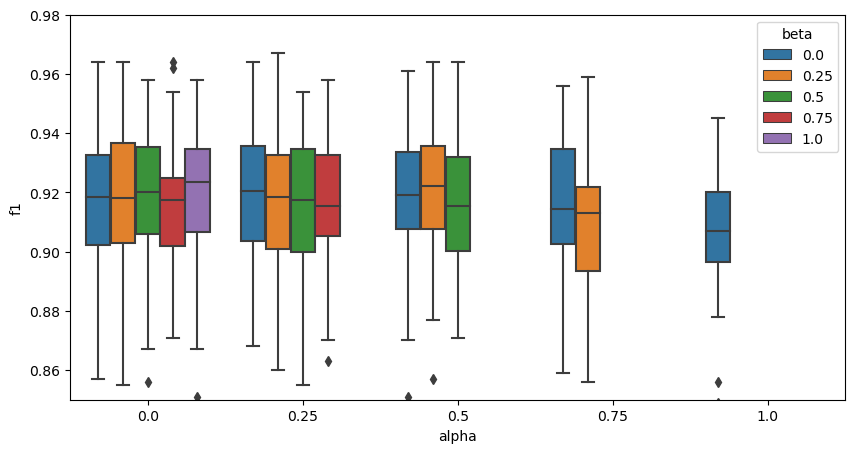

In [20]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='alpha', y='f1', hue='beta')
plt.ylim([0.85, 0.98])

<Axes: xlabel='alpha', ylabel='coverage_prop'>

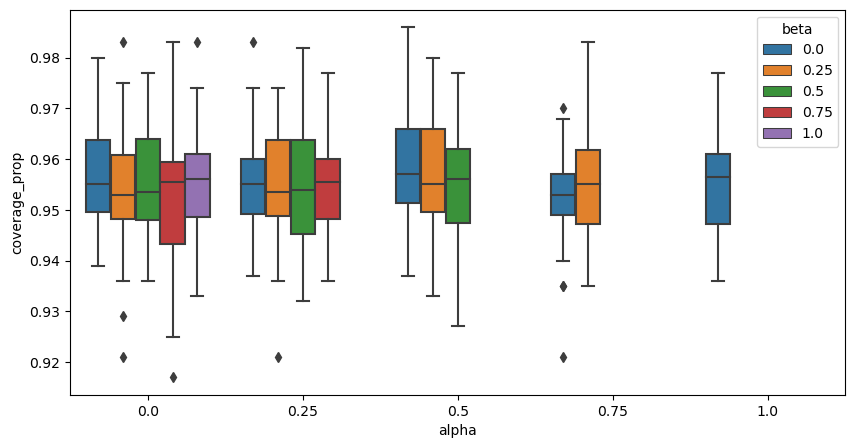

In [21]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='alpha', y='coverage_prop', hue='beta')

<Axes: xlabel='alpha', ylabel='intensity_prop'>

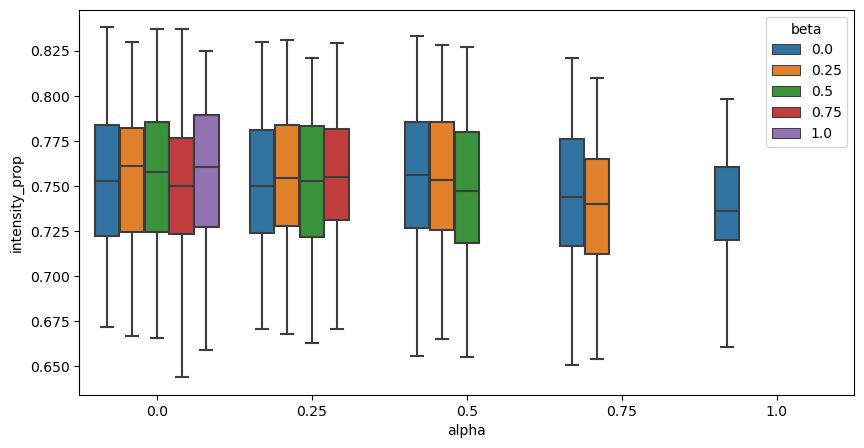

In [22]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='alpha', y='intensity_prop', hue='beta')